In [3]:
pip install torchinfo

In [1]:
pip install medmnist


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cach

In [12]:
#Import the required libraries
import torch
import time
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader,random_split
from medmnist.dataset import OCTMNIST
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
import torch.nn.init as init
from torchinfo import summary


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
#preprocessing and normalizing pixel values to a standardized range, typically between 0 and 1
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

OCTMNIST_data = OCTMNIST(split="train", download=True, transform=transform)

# Split the dataset into training (70%), validation (15%), and testing (15%) sets
total_size = len(OCTMNIST_data)
train_size = int(0.7 * total_size)
test_size = (total_size - train_size) // 2
valid_size = total_size - train_size - test_size

# Split the dataset into training, validation, and testing sets
trained_data, vaidated_data, tested_data = random_split(OCTMNIST_data, [train_size, valid_size, test_size])

# Print the size of the datasets
print("Length of trained_data:", len(trained_data))
print("Length of validated_data:", len(vaidated_data))
print("Length of tested_data:", len(tested_data))


# Create DataLoader instances for each dataset
batch_size = 64
train_loader = DataLoader(trained_data, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(vaidated_data, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(tested_data, batch_size=batch_size, shuffle=False, num_workers=2)

OCTMNIST_data

Using downloaded and verified file: /root/.medmnist/octmnist.npz
Length of trained_data: 68233
Length of validated_data: 14622
Length of tested_data: 14622


Dataset OCTMNIST of size 28 (octmnist)
    Number of datapoints: 97477
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'choroidal neovascularization', '1': 'diabetic macular edema', '2': 'drusen', '3': 'normal'}
    Number of samples: {'train': 97477, 'val': 10832, 'test': 1000}
    Description: The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the source training set with a ratio of 9:1 into training and validation set, and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−1,536)×(277−512). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0

# **Building a basic Convolutional neural network:**

In [9]:


class OCTMNIST_CNN(nn.Module):
    def __init__(self):
        super(OCTMNIST_CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 4)
        # Dropout layers
        self.dropout = nn.Dropout(0.1)

        #Initilizing the weights using Xavier initilization
        init.xavier_uniform_(self.fc1.weight)
        init.xavier_uniform_(self.fc2.weight)
        init.xavier_uniform_(self.fc3.weight)
        init.xavier_uniform_(self.fc4.weight)
        init.xavier_uniform_(self.fc5.weight)

    # Defining the forward pass function
    def forward(self, x):
        x = self.pool(self.relu1(self.conv1(x)))
        x = self.pool(self.relu2(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)  # Flatten the tensor
        x = self.relu1(self.fc1(x))
        x = self.dropout(x)
        x = self.relu2(self.fc2(x))
        x = self.dropout(x)
        x = self.relu1(self.fc3(x))
        x = self.dropout(x)
        x = self.relu2(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        return x

# Calling the model
model = OCTMNIST_CNN()
print(model)
#Printing the summary of the model
summary(model)



OCTMNIST_CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=4, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


Layer (type:depth-idx)                   Param #
OCTMNIST_CNN                             --
├─Conv2d: 1-1                            160
├─ReLU: 1-2                              --
├─Conv2d: 1-3                            4,640
├─ReLU: 1-4                              --
├─MaxPool2d: 1-5                         --
├─Linear: 1-6                            401,664
├─Linear: 1-7                            32,896
├─Linear: 1-8                            8,256
├─Linear: 1-9                            2,080
├─Linear: 1-10                           132
├─Dropout: 1-11                          --
Total params: 449,828
Trainable params: 449,828
Non-trainable params: 0

In [10]:
#Definig the loss function
criterion = nn.CrossEntropyLoss()
#Using Adam as optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# **Training the CNN model for 7 Epochs**


In [13]:

# Number of training epochs
num_epochs = 7

# Lists to store training and validation accuracies and loss values
train_losses = []
test_accuracies_early = []
train_accuracies=[]
test_losses = []
val_losses=[]
val_accuracies=[]
best_test_accuracy=0.0
start_time = time.time()
best_val_loss = float('inf')
no_improvement_count = 0
early_stopping_patience = 5
for epoch in range(num_epochs):
    model.train()  # Set the model in training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    #Enumerate over the trainloader
    for i, data in enumerate(train_loader,0):
        inputs,labels=data
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.view(-1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()


    # Calculate training accuracy and loss
    train_accuracy = 100 * correct_train / total_train
    train_loss = running_loss / len(train_loader)

    #Storing the training loss values for each batch into a list
    train_losses.append(train_loss)
    #similarly storing accuracies into a list
    train_accuracies.append(train_accuracy)



    # Validation phase
    model.eval()  # Set the model in evaluation mode
    validation_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():  # Disable gradient computation during validation

        #iterate over the val_loader
        for data in valid_loader:
            inputs, labels = data
            outputs = model(inputs)
            labels = labels.view(-1)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()

            # Calculate validation accuracy
            _,predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            #calculating correct predictions
            correct_val += (predicted == labels).sum().item()

    # Calculate validation accuracy and loss
    val_accuracy = 100 * correct_val / total_val
    val_loss = validation_loss / len(valid_loader)

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_count = 0


    else:
        no_improvement_count += 1

    if no_improvement_count >= early_stopping_patience:
        print(f'Early stopping at epoch {epoch}')
        break

    # Testing phase
    model.eval()  # Set the model in evaluation mode
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    predictions = []
    true_labels = []

    with torch.no_grad():  # Disable gradient computation during testing

        #iterate over the testloader
        for data in test_loader:
            inputs,labels=data
            outputs = model(inputs)
            labels = labels.view(-1)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            predictions.extend(predicted.numpy())
            true_labels.extend(labels.numpy())


    # Calculate training accuracy and loss
    test_accuracy = 100 * correct_test / total_test
    test_loss = running_loss / len(test_loader)

    #Storing the training loss values for each batch into a list
    test_losses.append(test_loss)
    #similarly storing accuracies into a list
    test_accuracies_early.append(test_accuracy)
    if test_accuracy > best_test_accuracy:
              best_test_accuracy = test_accuracy

    # Printing the training,testing and validation loss and accuracies for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}] Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')
    print(f'Epoch [{epoch + 1}/{num_epochs}] Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
    print(f'Epoch [{epoch + 1}/{num_epochs}] Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.2f}%')

print('Finished Training')
#calculating the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
#evaluation metrics
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Test Accuracy: {best_test_accuracy:.2f}%')
print(f'Final Precision: {precision:.4f}')
print(f'Final Recall: {recall:.4f}')
print(f'Final F1 Score: {f1:.4f}')
print(f"Training time: {elapsed_time:.2f} seconds")


Epoch [1/7] Training Loss: 0.7682, Training Accuracy: 71.75%
Epoch [1/7] Validation Loss: 0.5655, Validation Accuracy: 80.36%
Epoch [1/7] Testing Loss: 3.5795, Testing Accuracy: 80.13%
Epoch [2/7] Training Loss: 0.5237, Training Accuracy: 82.13%
Epoch [2/7] Validation Loss: 0.4657, Validation Accuracy: 83.76%
Epoch [2/7] Testing Loss: 2.4400, Testing Accuracy: 83.62%
Epoch [3/7] Training Loss: 0.4660, Training Accuracy: 84.08%
Epoch [3/7] Validation Loss: 0.4782, Validation Accuracy: 83.53%
Epoch [3/7] Testing Loss: 2.1713, Testing Accuracy: 83.31%
Epoch [4/7] Training Loss: 0.4407, Training Accuracy: 84.90%
Epoch [4/7] Validation Loss: 0.5136, Validation Accuracy: 82.53%
Epoch [4/7] Testing Loss: 2.0533, Testing Accuracy: 82.43%
Epoch [5/7] Training Loss: 0.4204, Training Accuracy: 85.55%
Epoch [5/7] Validation Loss: 0.4607, Validation Accuracy: 84.24%
Epoch [5/7] Testing Loss: 1.9587, Testing Accuracy: 83.93%
Epoch [6/7] Training Loss: 0.4097, Training Accuracy: 85.89%
Epoch [6/7] Va

In [16]:
import pickle


model_path = '/tmp/model_best_CNN.pkl'

# Save the model
with open(model_path, 'wb') as f:
    pickle.dump(model.state_dict(), f)
print(f"Model state dictionary saved to {model_path}")

# Load the model
with open(model_path, 'rb') as f:
    state_dict = pickle.load(f)


Model state dictionary saved to /tmp/model_best_CNN.pkl


# **Confusion Matrix**

[[4847  125   28   62]
 [ 131 1294    4  129]
 [ 436   75   78  570]
 [ 195  263   64 6321]]


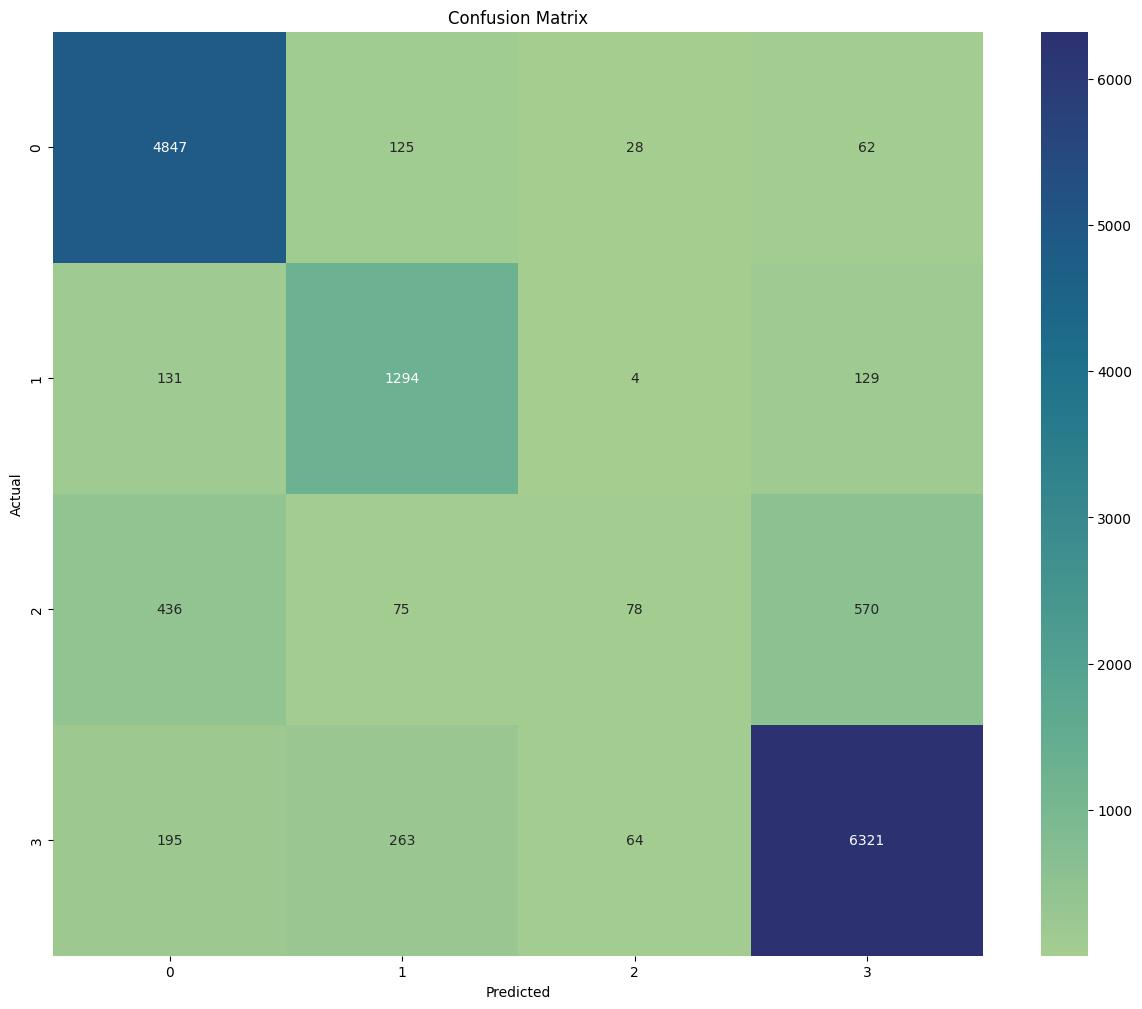

In [21]:

# Confusion Matrix
confusion = confusion_matrix(true_labels, predictions)
print(confusion)
plt.figure(figsize=(15, 12))
sns.heatmap(confusion, annot=True, fmt='d', cmap='crest')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# **Graphs for accuracy and loss**

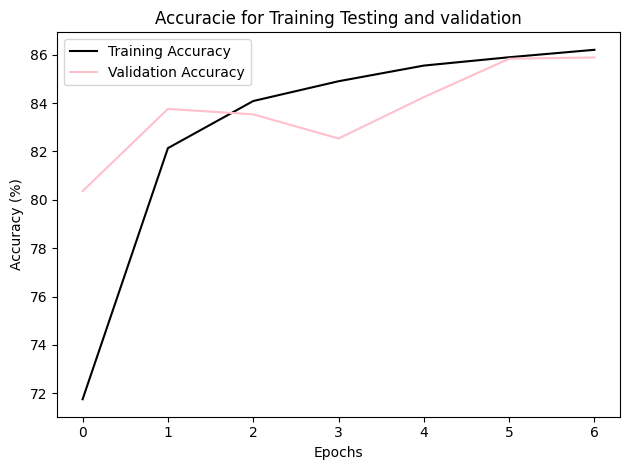

Text(0.5, 1.0, 'Loss graph for Training testing and validation')

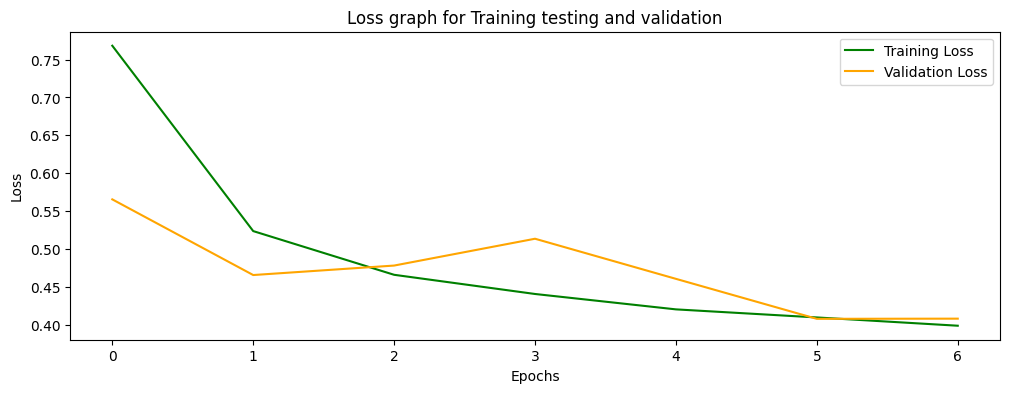

In [20]:
#Plot the training and validation accuracy over time (epochs).
plt.plot(train_accuracies, label='Training Accuracy', color='black')
plt.plot(val_accuracies, label='Validation Accuracy', color='pink')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracie for Training Testing and validation')
plt.tight_layout()
plt.show()

# Plot the training and validation loss over time (epochs).
plt.figure(figsize=(12, 4))

plt.plot(train_losses, label='Training Loss', color='green')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss graph for Training testing and validation')

references:
- https://github.com/MedMNIST/MedMNIST
- https://medmnist.com/
- https://zenodo.org/record/6496656
- My WORK from CSE:574 Machine_Learning Assignment2 by poojitha challa and Akanksha bannuru(my team mate)
